<a href="https://colab.research.google.com/github/nuvard/kern_segmentation/blob/master/transfer_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Baseline for transfer-learning

##Подготовка данных

In [0]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

from __future__ import print_function, division
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from torchvision.transforms import RandomVerticalFlip, RandomCrop

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/ kern/'

In [0]:
data = pd.read_csv(path+'data.csv')

In [6]:
data.head()


,Folder,Id,Field,Well,CoringTop,CoringDown,CoringTopBind,CoringDownBind,CoreRecovery,PhotoTop,PhotoDown,PhotoType,LayerTop,LayerDown,Rock,Carbonate,Ruin,Saturation
0,Unload1,1000000,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,ДС,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
1,Unload1,1000001,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
2,Unload1,1000002,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,ДС,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
3,Unload1,1000003,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
4,Unload1,1000004,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.45,2.00,ДС,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.


In [7]:
data.loc[data.Id==1000000,]

,Folder,Id,Field,Well,CoringTop,CoringDown,CoringTopBind,CoringDownBind,CoreRecovery,PhotoTop,PhotoDown,PhotoType,LayerTop,LayerDown,Rock,Carbonate,Ruin,Saturation
0,Unload1,1000000,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.0,1.00,ДС,0.0,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
1414,Unload2,1000000,Field4,Well4,2683.0,2692.0,2682.5,2691.5,8.98,0.0,0.48,ДС,0.0,0.48,песчаник,слабокарбонатный,не разрушен,не опред.


Мой диск не вмещает весь датасет, так что пока я буду работать только с первой скважиной.

Здесь я хочу отделить фото разных типов, чтобы натренировать две сетки - по одной на каждый тип.


In [0]:
data = data.loc[data.Folder=='Unload1', ]


In [0]:
data.to_csv(path+'data_1.csv')

Нам нужны не все классы, а только некоторые. Пока я подготовлю словари для переименования классов. 

In [0]:
satur_dict = {'не опред.': 'unknown', 'нефтенасыщенные': 'oil','битуминозный':'oil', 'продукт':'oil', 'пятнисто нефтенасыщенные': 'oil','слабо нефтенасыщенные':'oil' }

In [0]:
rock_dict = {"с карбонатными обломками или конкрециями": "с карб. обломками или конкрециями", \
             "пересл. кремнисто-глинистой породы и аргиллита": "пересл. кремн.-глинист. породы и аргиллитa", \
             "пересл. песчаника и глины аргиллитоподобной" : "пересл. песчаника и глины аргиллитоподобн."}

In [0]:
carbon_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [0]:
ruin_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [15]:
data.Carbonate.value_counts()

не карбонатный                              778
слабокарбонатный                            216
с карбонатными обломками или конкрециями    198
среднекарбонатный                            92
сильнокарбонатный                            90
с примесью                                   40
Name: Carbonate, dtype: int64

In [16]:
data.Rock.value_counts()

песчаник                                750
алевролит                               308
пересл. песчаника, алевролита и глин    168
аргиллит                                 92
песчаник глинистый                       74
алевро-аргиллит                          18
глина                                     4
Name: Rock, dtype: int64

In [17]:
data.Ruin.value_counts()

не разрушен          1172
частично разрушен     230
разрушен               12
Name: Ruin, dtype: int64

In [18]:
satur_dict

{'битуминозный': 'oil',
 'не опред.': 'unknown',
 'нефтенасыщенные': 'oil',
 'продукт': 'oil',
 'пятнисто нефтенасыщенные': 'oil',
 'слабо нефтенасыщенные': 'oil'}

Я подготовила функцию для ьыстрой замены классов.

In [0]:
def apply_class(data, column, class_dict):
  data['class']=data[column].apply(lambda x:class_dict[x] if (x in class_dict) else x)

In [0]:
apply_class(data,'Saturation', satur_dict)

In [0]:
#apply_class(data,'Rock', rock_dict)

In [25]:
data.head()

,Folder,Id,Field,Well,CoringTop,CoringDown,CoringTopBind,CoringDownBind,CoreRecovery,PhotoTop,PhotoDown,PhotoType,LayerTop,LayerDown,Rock,Carbonate,Ruin,Saturation,class
0,Unload1,1000000,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,ДС,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,oil
1,Unload1,1000001,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,oil
2,Unload1,1000002,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,ДС,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,oil
3,Unload1,1000003,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,oil
4,Unload1,1000004,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.45,2.00,ДС,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,unknown


In [22]:
data['class'].value_counts()

unknown    890
oil        524
Name: class, dtype: int64

In [0]:
data_dc = data.loc[data.PhotoType=='ДС',].reset_index(drop=True)
data_uf = data.loc[data.PhotoType!='ДС',].reset_index(drop=True)
#data_2 = data.loc[data.Folder=='Unload2', ]

In [0]:
data_dc.to_csv(path+'data_1_dc.csv')
data_uf.to_csv(path+'data_1_uf.csv')

In [27]:
data_dc.head()

,Folder,Id,Field,Well,CoringTop,CoringDown,CoringTopBind,CoringDownBind,CoreRecovery,PhotoTop,PhotoDown,PhotoType,LayerTop,LayerDown,Rock,Carbonate,Ruin,Saturation,class
0,Unload1,1000000,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,ДС,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,oil
1,Unload1,1000002,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,ДС,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,oil
2,Unload1,1000004,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.45,2.00,ДС,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,unknown
3,Unload1,1000006,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,2.00,3.00,ДС,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,unknown
4,Unload1,1000008,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,3.00,3.54,ДС,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,unknown


In [28]:
data_uf.head()

,Folder,Id,Field,Well,CoringTop,CoringDown,CoringTopBind,CoringDownBind,CoreRecovery,PhotoTop,PhotoDown,PhotoType,LayerTop,LayerDown,Rock,Carbonate,Ruin,Saturation,class
0,Unload1,1000001,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,oil
1,Unload1,1000003,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,oil
2,Unload1,1000005,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.45,2.00,УФ,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,unknown
3,Unload1,1000007,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,2.00,3.00,УФ,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,unknown
4,Unload1,1000009,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,3.00,3.54,УФ,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,unknown


Проверка актуальности таблицы

In [0]:
def check(data):
  for i in data.index:
    img_name=data.loc[i, 'Folder']+'/data/'+str(data.loc[i, 'Id'])+'.jpeg'

    #plt.figure()
    to_drop = []
    if not os.path.isfile(os.path.join(path, img_name)):
      to_drop.append(i)
      print("No image " + img_name)
    #plt.show()


In [0]:
check(data_dc)


In [0]:
check(data_uf)

##Создание датасета

In [0]:
class KernDataset(Dataset):
    """Kern dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.labels_path = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #print(csv_file)
        img_name = os.path.join(self.root_dir,
                                self.data.loc[idx, 'Folder']+'/data/'+str(self.data.loc[idx, 'Id'])+'.jpeg')
        #print(img_name)
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        
        label = self.data.loc[idx, 'class']
        sample = {'image': image, 'class_name': label}
        return DatasetItem(image=image, label=label, id=idx, path=img_name)

Заготовка на будущее?

In [0]:
'''
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, class_name = sample['image'], sample['class_name']

        h = image.shape[0]
        new_h  = self.output_size[0]
        new_w = image.shape[1]

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'class_name': class_name}

      
class RandomHorizontalFlip(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, class_name = sample['image'], sample['class_name']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

'''

In [0]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [0]:
def show_batch_image(image_batch, batch_size=4, name='out.png'):
    """
    Show a sample grid image which contains some sample of test set result
    :param image_batch: The output batch of test set
    :return: PIL image of all images of the input batch
    """

    to_pil =  transforms.ToPILImage()
    fs = []
    for i in range(batch_size):
        img = to_pil(image_batch.images[i].cpu())
        fs.append(img)
    x, y = fs[0].size
    ncol = int(np.ceil(np.sqrt(batch_size)))
    nrow = int(np.ceil(np.sqrt(batch_size)))
    cvs = Image.new('RGB', (x * ncol, y * nrow))
    for i in range(len(fs)):
        px, py = x * int(i / nrow), y * (i % nrow)
        cvs.paste((fs[i]), (px, py))
    print(name)
    cvs.save(name, format='png')
    #cvs.show()
    plt.imshow(np.asarray(cvs))


In [0]:
transform = transforms.Compose(
    [
        
        transforms.RandomResizedCrop((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

train_dataset_uf = KernDataset(csv_file=path+'data_1_uf.csv',
                                    root_dir=path, transform=transform)

train_dataset_dc = KernDataset(csv_file=path+'data_1_dc.csv',
                                    root_dir=path, transform=transform)


train_loader_uf = torch.utils.data.DataLoader(
    train_dataset_uf,
    batch_size=4,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4,
)

train_loader_dc = torch.utils.data.DataLoader(
    train_dataset_dc,
    batch_size=4,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4,
)

Проверка, правильно ли считываются картинки

out.png


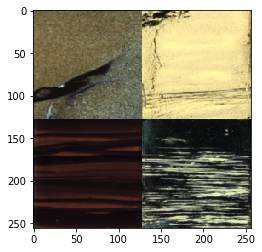

In [41]:
show_batch_image(next(iter(train_loader_uf)))


In [0]:
def train(model, device, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {} [ ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )
    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )


def test(model, device, test_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    writer.add_scalar("test_loss_plot", test_loss, global_step=epoch)
    writer.add_scalar(
        "test_accuracy_plot",
        100.0 * correct / len(test_loader.dataset),
        global_step=epoch,
    )

In [0]:
model = models.resnet18()
model.fc = nn.Linear(512, 2)
model = model.to(0)

optimizer = optim.SGD(model.parameters(), lr=1e-3)

loss_function = loss.CrossEntropyLoss()

In [55]:
!pip install tensorboardX
from tensorflow import summary

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 1.3MB 38.5MB/s 
  Found existing installation: protobuf 3.7.1
    Uninstalling protobuf-3.7.1:
      Successfully uninstalled protobuf-3.7.1


In [56]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
import datetime

In [0]:
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = path+'logs/tensorboard/train/' + current_time
test_log_dir = path+'logs/tensorboard/test/' + current_time
train_writer = SummaryWriter(train_log_dir)
test_summary_writer =  SummaryWriter(test_log_dir)

In [62]:
tensorboard --logdir train_log_dir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 10, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 64, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 220, in main
    server = self._make_server()
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 299, in _make_server
    self.assets_zip_provider)
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/backend/application.py", line 160, in standard_tensorboard_wsgi
    flags, plugin_loaders, data_provider, assets_zip_provider, mul

In [0]:
tensorboard --logdir runs --port 6007

In [0]:
ssh -X -L 16006:127.0.0.1:6007 cosmos@my_server_ip